# Wigner function transform from Density Matrix
# 1. Load packages 

In [76]:
import numpy as np
import scipy.fftpack as fftpack

import pylab as plt
import matplotlib.cm as cm

import scipy.linalg as linalg
from scipy.special import hermite
from scipy.special import laguerre
from numpy import fft

import cv2

%matplotlib inline

# 2. Useful functions
### 2.1 Analytical Density Matrix 
Example made for the harmonic oscillator:

$$ \psi_n(x) = e^{jp_0 (x-x_0)} \cdot e^{
- \frac{m\omega (x-x_0)^2}{2 \hbar}} \cdot H_n\left(\sqrt{m\omega} (x-x_0) \right), \qquad n = 0,1,2,\ldots. $$

$$ \hat{\rho} = \left|\psi\right\rangle \left\langle \psi \right| $$

In [77]:
def Psi_HarmonicOscillator( hBar, n, mass, omega, X0, P0, X ):

		k = np.sqrt(mass*omega ) 
        
		return np.exp(1j*P0*(X-X0))*np.exp( -0.5*k**2*(X-X0)**2 )*hermite(n)( k*(X-X0) )
    
    

def Rho_HarmonicOscillator( hBar, n, mass, omega, X0,P0, X_range ):
        """
        Rho initial state in the X representation
        Parameters:
			n
            mass
            omega
			X0
			P0
            X_range
		Returns:
			Rho harmonic oscillator  matrix state    
		"""
        gridDIM = X_range.shape[0]
        X_row = X_range.reshape( (1,gridDIM) )
        X_col = X_range.reshape( (gridDIM,1) ) 		
        Rho = np.conj(Psi_HarmonicOscillator(hBar,n,mass,omega,X0,P0,X_col)).dot(
                                                Psi_HarmonicOscillator(hBar,n,mass,omega,X0,P0,X_row))    
        norm = np.trace(Rho)
        return Rho/norm


### 2.2 Analytical Wigner Function

In [78]:
def  Wigner_HarmonicOscillator(n,mass,omega,x,p,X_range,P_range,dX,dP):
    """
    Wigner function of the Harmonic oscillator
            Parameters
            x,p  : center of wave packet
            n    : Quantum number  
    """
    X = fftpack.fftshift(X_range)[np.newaxis,:]
    P = fftpack.fftshift(P_range)[:, np.newaxis]
    
    
    r2 = mass*omega**2*((X - x))**2 + ((P - p ))**2/mass 
    
    W = (-1)**(n)*laguerre(n)( 2*r2  )*np.exp(-r2 )
    
    W /= np.sum(W)*dX*dP
    
    return  W

In [79]:
def W_semi_analytical( hBar, n, mass, omega, X0, P0, X_range , P_range, dX,dP ):
    
    X_amplitude = np.max(X_range)
    P_amplitude = np.max(P_range)
    
    X_gridDIM = X_range.shape[0]
    P_gridDIM = P_range.shape[0]
    
    X = fftpack.fftshift(X_range)[np.newaxis,:]
    P = fftpack.fftshift(P_range)[:, np.newaxis]
    
    
    dTheta  = 2.*np.pi/(2.*P_amplitude)
    Theta_amplitude = dTheta*P_gridDIM/2.
    dLambda = 2.*np.pi/(2.*X_amplitude)
    Lambda_amplitude = dLambda*X_gridDIM/2.
   
    
    Lambda_range =  np.linspace(-Lambda_amplitude , Lambda_amplitude-dLambda  , X_gridDIM)
    Theta_range  = np.linspace(-Theta_amplitude  , Theta_amplitude - dTheta , P_gridDIM)
    
    
    Theta  = fftpack.fftshift(Theta_range)[:,np.newaxis]
    Lambda = fftpack.fftshift(Lambda_range)[np.newaxis,:]
    
    # Calling function Psi_coherent
    
    PhiPlus = Psi_HarmonicOscillator( hBar, n, mass, omega, X0, P0, X + hBar*Theta/2 )
    PhiMinus = Psi_HarmonicOscillator( hBar, n, mass, omega, X0, P0, X - hBar*Theta/2 )
     
            
    # B matrix
    
    B = np.conj(PhiPlus)*PhiMinus
    
    # W matrix
    
    W = fftpack.ifft(B,axis=0)
    
    # Normalization
    
    W /= np.sum(W)*dX*dP
    
    return W

### 2.3 Density Matrix to Wigner function

In [80]:
def RotateRho(Rho,angle):
		# with padding
		rows,cols = Rho.shape
		#pix_extra = int(round(max(Rho.shape)*(np.sqrt(2.)-1)/2))
		pix_extra = 0 #rows/2
		#
		Rho2 = np.lib.pad(Rho, [(pix_extra,pix_extra), (pix_extra,pix_extra)], 'constant', constant_values=(0,0))
		#Rho2 = np.lib.pad(Rho, [(pix_extra,pix_extra), (pix_extra,pix_extra)], 'linear_ramp', end_values=(0, 0))
	       
		rows,cols = Rho2.shape
		M = cv2.getRotationMatrix2D((cols/2,rows/2), angle ,1)
		
		Rho2_real = cv2.warpAffine( Rho2.real ,M,(cols,rows))
		Rho2_imag = cv2.warpAffine( Rho2.imag ,M,(cols,rows))
			    
		return Rho2_real + 1j*Rho2_imag
    
    

def DensityMatrix_To_Wigner(Rho,dX,dP):
    
        rho_rotated45 = RotateRho(Rho,45)
        
        rho_rotated45 = fftpack.ifftshift( rho_rotated45 , axes=0 )
        W = fftpack.ifftshift( fftpack.ifft( rho_rotated45, axis=0 ) , axes=0)
        
        ## take only " the First half +1 " of rho_rotated45 for the axes =0
        ##rho_rotated45 = rho_rotated45[: (1+X_gridDIM//2 ) , :]
        ##W = fftpack.fftshift(  fft.irfft( rho_rotated45, axis=0 ) , axes=0  )
        norm = np.sum(W)*dX*dP;
        W /= norm
        #  W.T[::-1,:]*2
        return  W


### 3. Specify System's Quantum Parameters in atomic units

In [81]:
X_gridDIM = 256

X_amplitude =  20

dX = 2*X_amplitude/float(X_gridDIM)
dP = 2.*np.pi/(2.*X_amplitude)

P_amplitude = dP*X_gridDIM/2.

X_range = np.linspace( -X_amplitude,X_amplitude-dX,X_gridDIM )
P_range = np.linspace( -P_amplitude, P_amplitude-dP, X_gridDIM )

print X_amplitude , P_amplitude 

20 20.106192983


### EXAMPLES
### 4. Density matrix $\rho(x,x')$

Renormalization:  (1+0j)
Real volume:  0.819435611522


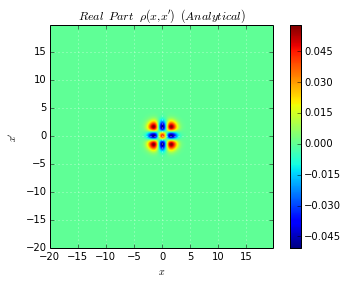

In [82]:
# Parameters

hBar=1
omega = 1
mass =1
n = 2
X_init = 0
P_init = 0

# Compute Harmonic oscillator rho

rho_exact = Rho_HarmonicOscillator(hBar, n , mass, omega, X_init , P_init, X_range);

# Check normalization
 
print "Renormalization: ", np.trace(rho_exact)
print "Real volume: ", np.sum(  np.abs(rho_exact.real)  )*dX**2

# Plot real part Harmonic oscillator rho

extent_rho = [ -X_amplitude , X_amplitude - dX , -X_amplitude , X_amplitude - dX  ]

plt.imshow( np.real( rho_exact  ) , extent=extent_rho, origin='lower', aspect=1 )

plt.xlabel("$x$")
plt.ylabel("$x'$")
plt.title(r"$ Real  \ \  Part  \ \  \rho (x,x')  \ \ (Analytical) $")
plt.colorbar()
plt.grid(color='white')

 Imagiary volume:  0.0


<matplotlib.colorbar.Colorbar instance at 0x7f14b6644c68>

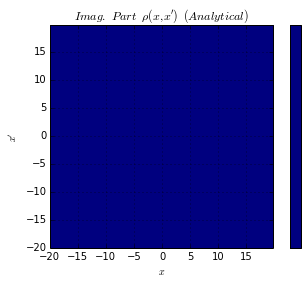

In [83]:
# Plot imaginary part 
print " Imagiary volume: ", np.sum(  np.abs(rho_exact.imag)  )*dX**2

plt.imshow( np.imag( rho_exact  ) , extent=extent_rho, origin='lower', aspect=1 )
plt.title(r"$ Imag.  \ \  Part  \ \  \rho (x,x')  \ \ (Analytical) $")
plt.grid(c='k')
plt.xlabel("$x$")
plt.ylabel("$x'$")
plt.colorbar()

### 5. Analytical Wigner function 

In the below code notice that I am scaling X_range , P_range, dX and dP by square root of 2 in order to be able to compare
the Wigner function generated by the rotation with this analytical version.

Renormalization:  1.0
Real volume:  1.72994654394


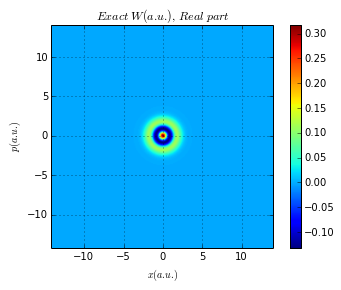

In [84]:
# Get the exact Wigner function

W_exact = Wigner_HarmonicOscillator(n,mass,omega,X_init ,P_init , 
                                    X_range/np.sqrt(2),  P_range/np.sqrt(2), dX/np.sqrt(2), dP/np.sqrt(2))

# Plot the Wigner function


extent_W_scaling = [-X_amplitude/np.sqrt(2) , X_amplitude/np.sqrt(2) - dX/np.sqrt(2) ,
                    -P_amplitude/np.sqrt(2) , P_amplitude/np.sqrt(2) - dP/np.sqrt(2) ]


plt.imshow(  fftpack.fftshift(W_exact.real), extent = extent_W_scaling , origin= "lower", aspect = 1  ) 
plt.grid(c='k')
plt.colorbar()
plt.xlabel("$x(a.u.)$")
plt.ylabel("$p(a.u.)$")
plt.title("$Exact \\ W(a.u.), \\ Real \\ part$")

# below note that I am dividing the Renormalization and the real volume by 2, since both dX and dP are 
# scaled by the square root of 2.

print "Renormalization: ", np.sum(W_exact.real)*dX*dP/2
print "Real volume: ", np.sum(np.abs(W_exact.real))*dX*dP/2

Imag. volume:  0.0


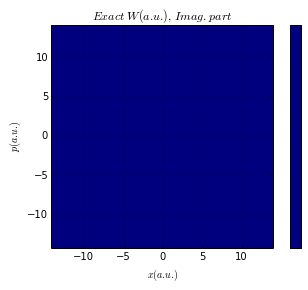

In [85]:
# Plot imaginary part

plt.imshow(  fftpack.fftshift(W_exact.imag), extent = extent_W_scaling , origin= "lower", aspect = 1  ) 
plt.grid(c='k')
plt.colorbar()
plt.xlabel("$x(a.u.)$")
plt.ylabel("$p(a.u.)$")
plt.title("$Exact \\ W(a.u.), \\ Imag. \\ part$")

print "Imag. volume: ", np.sum(np.abs(W_exact.imag))*dX*dP/2

### 6. Semi analytical Wigner function 
In the below code notice that I am scaling X_range , P_range, dX and dP by square root of 2 in order to be able to compare
the Wigner function generated by the rotation with this analytical version and the analytical one.

Renormalization:  1.0
Real volume:  1.7296268744


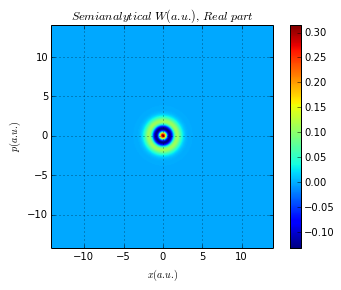

In [86]:
# Get the semi analytical Wigner function

W_semiA = W_semi_analytical( hBar, n, mass, omega, X_init, P_init, X_range/np.sqrt(2) , 
                            P_range/np.sqrt(2), dX/np.sqrt(2),dP/np.sqrt(2) )



# Plot the Wigner function


extent_W_scaling = [-X_amplitude/np.sqrt(2) , X_amplitude/np.sqrt(2) - dX/np.sqrt(2) ,
                    -P_amplitude/np.sqrt(2) , P_amplitude/np.sqrt(2) - dP/np.sqrt(2) ]


plt.imshow(  fftpack.fftshift(W_semiA.real), extent = extent_W_scaling , origin= "lower", aspect = 1  ) 
plt.grid(c='k')
plt.colorbar()
plt.xlabel("$x(a.u.)$")
plt.ylabel("$p(a.u.)$")
plt.title("$Semianalytical \\ W(a.u.), \\ Real \\ part$")

# below note that I am dividing the Renormalization and the real volume by 2, since both dX and dP are 
# scaled by the square root of 2.

print "Renormalization: ", np.sum(W_semiA.real)*dX*dP/2
print "Real volume: ", np.sum(np.abs(W_semiA.real))*dX*dP/2

Imag. volume:  1.43425881622e-15


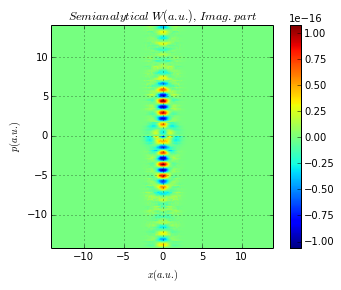

In [87]:
# Plot imaginary part

plt.imshow(  fftpack.fftshift(W_semiA.imag), extent = extent_W_scaling , origin= "lower", aspect = 1  ) 
plt.grid(c='k')
plt.colorbar()
plt.xlabel("$x(a.u.)$")
plt.ylabel("$p(a.u.)$")
plt.title("$ Semianalytical \\ W(a.u.), \\ Imag. \\ part$")

print "Imag. volume: ", np.sum(np.abs(W_semiA.imag))*dX*dP/2

### 6. Compare $W_{exact}$ with $W_{semiA.}$
I think this comparison tell us more or less the degree of numerical noise that we must expect in the computation 
of the Wigner transform followed by the rotation and the ifft

In [88]:
print "Difference of 'real volume' between W_semiA and W_approx", \
np.sum( np.abs( W_semiA.real - W_exact.real) )*dX*dP/2
print ""
print "Difference of 'imaginary volume' between W_semiA and W_approx", \
np.sum( np.abs(W_semiA.imag - W_exact.imag) )*dX*dP/2

Difference of 'real volume' between W_semiA and W_approx 0.0292442604303

Difference of 'imaginary volume' between W_semiA and W_approx 1.43425881622e-15


### 7. Wigner transform $\rho(x,x') \rightarrow W_{approx.}(x,p)$

Renormalization:  1.0
Real volume:  1.74234796303


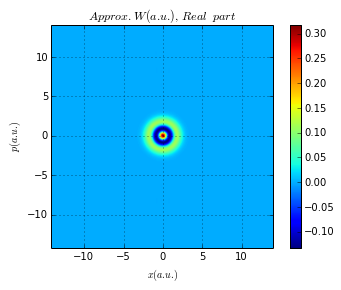

In [89]:
# Note that here I am scaling dX, dP since in the rotation routine we don't introduce X_range rescaled in
# the rotation routine but itself reescale X_range so then to normalize "W" we should rescale dX and dP

W_approx = DensityMatrix_To_Wigner(rho_exact,dX/np.sqrt(2)  ,dP/np.sqrt(2) )


# Plot

extent_W_approx = [-X_amplitude/np.sqrt(2) , X_amplitude/np.sqrt(2) - dX/np.sqrt(2) , 
                   
                   -P_amplitude/np.sqrt(2) , P_amplitude/np.sqrt(2) - dP/np.sqrt(2) ]

plt.imshow(  W_approx.real, extent = extent_W_approx, origin= "lower", aspect = 1  ) 
plt.grid(c='k')
plt.colorbar()
plt.xlabel("$x(a.u.)$")
plt.ylabel("$p(a.u.)$")
plt.title("$Approx. \\ W(a.u.), \\ Real \ \  part$")

# below note that I am dividing the Renormalization and the real volume by 2, since both dX and dP are 
# scaled by the square root of 2.

print "Renormalization: ", np.sum(W_approx.real)*dX*dP/2
print "Real volume: ", np.sum(np.abs(W_approx.real))*dX*dP/2

Imaginary volume:  5.87257755909e-16


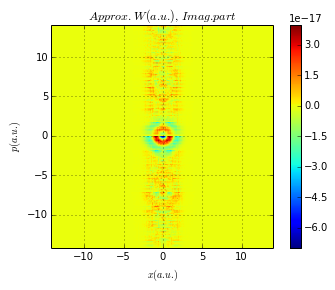

In [90]:
# Plot imaginary part

plt.imshow(  W_approx.imag , extent = extent_W_approx, origin= "lower", aspect=1) 
plt.colorbar()
plt.grid(c= 'k')
plt.xlabel("$x(a.u.)$")
plt.ylabel("$p(a.u.)$")
plt.title("$Approx. \\ W(a.u.), \\ Imag. part$")

# below note that I am dividing the Renormalization and the real volume by 2, since both dX and dP are 
# scaled by the square root of 2.
print "Imaginary volume: ", np.sum(np.abs(W_approx.imag))*dX*dP/2

### 9. How Hermitian is the rotated  density matrix 

In [92]:
# Rho exact rotated

rho_exact_rotated = RotateRho( rho_exact , 45 )

# Take the conjugate transpose

rho_rotated_T_conj = np.conj(rho_exact_rotated.T)

In [93]:
print " Hermitian measure 'Rho': ", np.sum(    np.conj(rho_exact.T)   -   rho_exact    )
print " The trace of 'Rho' must be real: ", np.trace(rho_exact)
print ""
print " Hermitian measure 'Rotated rho', REAL PART : ", np.sum(np.abs( rho_rotated_T_conj.real - rho_exact_rotated.real ))
print " Hermitian measure 'Rotated rho', IMAG PART : ", np.sum(np.abs( rho_rotated_T_conj.imag - rho_exact_rotated.imag ))
print " Hermitian measure 'Rotated rho', ABS. VALUE : ", np.sum(np.abs( np.abs(rho_rotated_T_conj) - np.abs(rho_exact_rotated) ))
print ""
print " The trace of 'Rotated rho' must be real: ", np.trace( rho_exact_rotated )
print " The trace of 'Rotated rho conj. transpose' must be real: ", np.trace( rho_rotated_T_conj )
print ""
print " Max. value of 'rho rotated'", np.max(rho_exact_rotated)
print " Sum of the absolute REAL values in 'Rotated rho'", np.sum(np.abs(rho_exact_rotated.real))
print " Sum of the absolute REAL values in 'Rotated rho conj. transpose'", np.sum(np.abs(rho_rotated_T_conj.real))


 Hermitian measure 'Rho':  0j
 The trace of 'Rho' must be real:  (1+0j)

 Hermitian measure 'Rotated rho', REAL PART :  0.011909159405
 Hermitian measure 'Rotated rho', IMAG PART :  0.0
 Hermitian measure 'Rotated rho', ABS. VALUE :  0.011909159405

 The trace of 'Rotated rho' must be real:  (-0.499828258354+0j)
 The trace of 'Rotated rho conj. transpose' must be real:  (-0.499828258354+0j)

 Max. value of 'rho rotated' (0.0574028482808+0j)
 Sum of the absolute REAL values in 'Rotated rho' 33.1956073326
 Sum of the absolute REAL values in 'Rotated rho conj. transpose' 33.1956073326
